In [1]:
%matplotlib inline

import contextlib

import numpy
from numpy import cross, eye, dot
from numpy import mgrid, pi, sin, cos, arccos
from numpy import allclose, linspace, array, empty_like
from numpy import vectorize, roll
from numpy.linalg import norm

import scipy
from scipy.linalg import expm

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cmx
import matplotlib.colors as colors

import voronoi

@contextlib.contextmanager
def plot3d():
    fig = plt.figure()
    fig.set_size_inches(7.5, 7.5)
    ax = fig.add_subplot('111', projection='3d')

    yield ax
    
def circumradii(triangle, center):
    return voronoi.great_circle_distance(center, triangle[0])

def Delaunay_circumradii(triangles, centers):
    N, _, _ = triangles.shape
    
    return numpy.array([circumradii(triangles[i], centers[i])
                        for i in range(N)])

def draw_sphere(ax):
    u, v = mgrid[0: 2 * pi: 50j, 0: pi: 25j]
    x = cos(u) * sin(v)
    y = sin(u) * sin(v)
    z = cos(v)
    
    ax.plot_surface(x, y, z, 
                    rstride=1, cstride=1, 
                    color="y", alpha=0.1, linewidth=0.)
    
def draw_origin(ax):
    ax.scatter(0, 0, 0, c='k', marker='*')
    
def draw_hull(ax, vertices):
    ax.plot_trisurf(vertices[0, :], vertices[1, :], vertices[2, :], 
                    triangles=hull.simplices,
                    cmap=mpl.cm.jet, alpha=0.2)  

def draw_points(ax, points):
    ax.scatter(points[0, :], points[1, :], points[2, :],c='darkolivegreen')

def rotate(axis, angle, whom):
    return dot(expm(cross(eye(3), axis * angle)), whom)

def draw_circumcircle(ax, center, radius):
    num_points = 100
    theta = linspace(0, 2 * pi, num_points)
    
    north = array([0., 0., 1.])
    
    if allclose(north, center):
        start = array([sin(radius), 0., cos(radius)])
    else:
        normal = cross(north, center)
        normal = normal / norm(normal)
        
        start = rotate(normal, radius, center)

    points = array([rotate(center, th, start) for th in theta])
    ax.plot(points[:, 0], points[:, 1], points[:, 2], c='grey', alpha=0.4)
        
def draw_circumcenters(ax, centers):
    ax.scatter(centers[:, 0], centers[:, 1], 
               centers[:, 2], c='r', marker='.')

def draw_arc(ax, start, finish):
    normal = cross(start, finish)
    normal = normal / norm(normal)

    angle = arccos(start.dot(finish))
    num_points = round(angle * 180 / pi)

    if num_points <= 2:
        num_points = 3

    theta = numpy.linspace(0, angle, num_points)

    points = numpy.array([rotate(normal, th, start) for th in theta])
    ax.plot(points[:, 0], points[:, 1], points[:, 2], c='b', alpha=0.1)

def draw_cells(ax, cells):
    for vertex, cell in cells.iteritems():
        segments = zip(cell, numpy.roll(cell, 1, axis=0))
        
        for start, finish in segments:
            draw_arc(ax, start, finish)

def draw_triangle(ax, triangle):
    draw_arc(ax, triangle[0], triangle[1])
    draw_arc(ax, triangle[1], triangle[2])
    draw_arc(ax, triangle[2], triangle[0])
    draw_points(ax, triangle)
    draw_circumcenters(ax,
                       numpy.array([voronoi.circumcircle(triangle)[0]]))
        
def draw_polygon_cells(ax, cells, points, level=5):
    
    # convert to Qhull indices
    points = points.T
    
    def circumcenter(triangle):
        center, _ = voronoi.circumcircle(array(triangle))
        return center.tolist()
    
    def poly_area(rim):
        return voronoi.polygon_area(array(rim))
    
    def flatten(list_of_lists):
        return [x for ls in list_of_lists for x in ls]
        
    def normalize(vec):
        return (array(vec) / norm(array(vec))).tolist()
    
    def mid(a, b):
        return normalize(array(a) + array(b))
    
    def divide(tri, level):
        a, b, c = tri
        
        if level == 0:
            return [[a, b, c]]
        
        A, B, C = mid(b, c), mid(c, a), mid(a, b)
        
        l = level - 1
        
        return flatten([divide([a, B, C], l), 
                divide([b, C, A], l), 
                divide([c, A, B], l), 
                divide([A, B, C], l)])
        
            
    for vertex, cell in cells.iteritems():
        random_color = colors.rgb2hex(scipy.rand(3) * 0.5 + 0.5)
        
        rim = cell.tolist()
        internal = points[vertex].tolist()
        segments = zip(rim, roll(array(rim), 1, axis=0).tolist())
        
        polys = [list(segment) + [internal] for segment in segments]
        
        if level == 0:
            polygons = [cell]
        else:
            polygons = flatten([divide(poly, level - 1) 
                               for poly in polys])
        
        

        polygon_collection = Poly3DCollection(polygons, 
                                              alpha=0.75, linewidth=0.)
        polygon_collection.set_color(random_color)
        ax.add_collection3d(polygon_collection)
        
    ax.set_xlim((-1,1))
    ax.set_ylim((-1,1))
    ax.set_zlim((-1,1))
    
excluded_angle = 0.
def criteria(point):
    theta, phi = point
    return theta > excluded_angle

In [2]:
while True:
    theta, phi = voronoi.random_points(8, criteria)
    points = voronoi.angular_to_cartesian(theta, phi)
    if voronoi.is_origin_inside(points):
        break
        
hull = voronoi.convex_hull(points)
triangles = voronoi.Delaunay_triangulation(hull)
centers = voronoi.Delaunay_circumcenters(triangles)
radii = Delaunay_circumradii(triangles, centers)

cells = voronoi.Voronoi_decomposition(points)

/home/zannat/.local/lib/python2.7/site-packages/ipykernel_launcher.py:96: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


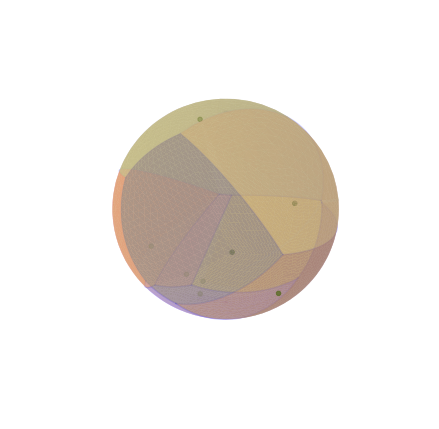

In [3]:
with plot3d() as ax:
    ax.set_axis_off()
    draw_sphere(ax)
    draw_polygon_cells(ax, cells, points)
    draw_points(ax, points)
    draw_cells(ax, cells)
    draw_circumcircle(ax,numpy.array([0., 0., 1.]), excluded_angle)

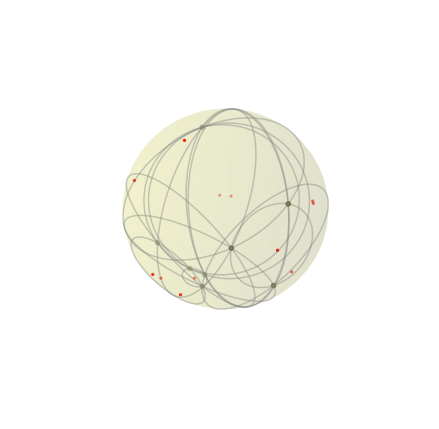

In [4]:
with plot3d() as ax:
    ax.set_axis_off()

    draw_sphere(ax)

    for i in range(len(centers)):
        draw_circumcircle(ax,centers[i], radii[i])

    draw_points(ax, points)
    draw_circumcenters(ax, centers)